导入必要的库并自定义一个简单模型

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.fc(x)

加载 MNIST 数据集

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3991775.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 112059.44it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1107073.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1078311.47it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



定义 DLG 攻击函数并执行攻击

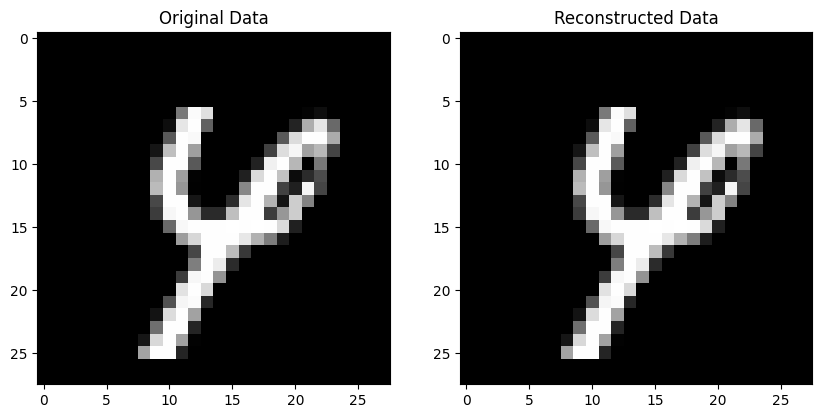

In [4]:
def dlg_attack(model, original_grad, target_label, lr=0.1, iterations=1000):
    # 初始化随机数据
    dummy_data = torch.randn(1, 1, 28, 28, requires_grad=True)
    dummy_label = torch.tensor([target_label], dtype=torch.long)

    optimizer = optim.LBFGS([dummy_data], lr=lr)

    for i in range(iterations):
        def closure():
            optimizer.zero_grad()
            dummy_output = model(dummy_data)
            dummy_loss = nn.CrossEntropyLoss()(dummy_output, dummy_label)
            dummy_grad = torch.autograd.grad(dummy_loss, model.parameters(), create_graph=True)
            
            grad_diff = sum(((dummy_grad[i] - original_grad[i]) ** 2).sum() for i in range(len(original_grad)))
            grad_diff.backward()
            return grad_diff

        optimizer.step(closure)

    return dummy_data

# 初始化模型
model = SimpleModel()
data, target = next(iter(train_loader))
# 计算原始梯度
output = model(data)
loss = nn.CrossEntropyLoss()(output, target)
original_grad = torch.autograd.grad(loss, model.parameters())

# 执行 DLG 攻击
reconstructed_data = dlg_attack(model, original_grad, target.item())

# 显示原始数据和重建数据
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Data")
plt.imshow(data[0].squeeze(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Data")
plt.imshow(reconstructed_data.detach().numpy().squeeze(), cmap='gray')

plt.show()

可以看到原始数据和通过 DLG 重建的数据。尽管重建的数据可能与原始数据不完全一致，但可以看出 DLG 能够在一定程度上恢复原始数据。

### DLG对应的信息正则化防御

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#定义互信息正则化项
def mutual_information_regularization(model, data, target):
    output = model(data)
    # 使用交叉熵作为互信息的近似
    loss = nn.CrossEntropyLoss()(output, target)
    return loss

In [6]:
#定义防御训练函数
def train_with_defense(model, train_loader, defense_lambda=0.1, epochs=5):
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            # 原始损失
            loss = criterion(output, target)
            # 互信息正则化项
            mi_loss = mutual_information_regularization(model, data, target)
            # 总损失
            total_loss = loss + defense_lambda * mi_loss
            total_loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss.item()}")

In [7]:
# 初始化模型
model = SimpleModel()

# 训练模型并应用互信息正则化防御
train_with_defense(model, train_loader, defense_lambda=0.1, epochs=5)

Epoch 1/5, Loss: 0.3995649814605713
Epoch 2/5, Loss: 0.000987229635939002
Epoch 3/5, Loss: 0.08845642954111099
Epoch 4/5, Loss: 0.3800903260707855
Epoch 5/5, Loss: 0.00025174120673909783


执行 DLG 攻击并验证防御效果

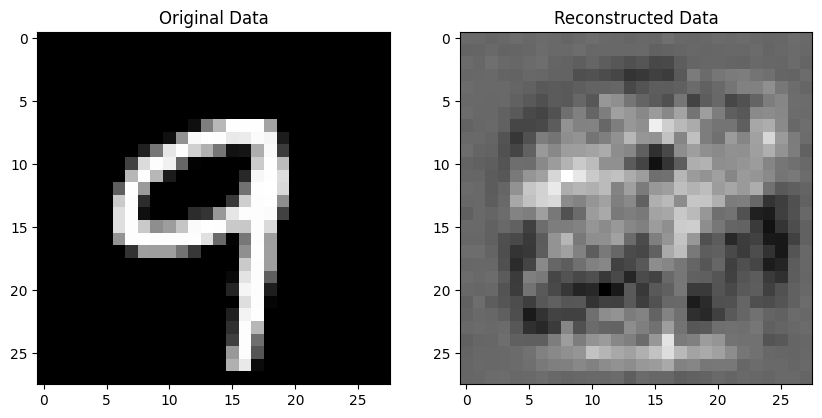

In [8]:
def dlg_attack(model, original_grad, target_label, lr=0.1, iterations=1000):
    dummy_data = torch.randn(1, 1, 28, 28, requires_grad=True)
    dummy_label = torch.tensor([target_label], dtype=torch.long)

    optimizer = optim.LBFGS([dummy_data], lr=lr)

    for i in range(iterations):
        def closure():
            optimizer.zero_grad()
            dummy_output = model(dummy_data)
            dummy_loss = nn.CrossEntropyLoss()(dummy_output, dummy_label)
            dummy_grad = torch.autograd.grad(dummy_loss, model.parameters(), create_graph=True)
            
            grad_diff = sum(((dummy_grad[i] - original_grad[i]) ** 2).sum() for i in range(len(original_grad)))
            grad_diff.backward()
            return grad_diff

        optimizer.step(closure)

    return dummy_data

# 选择一个样本进行攻击
data, target = next(iter(train_loader))

# 计算原始梯度
output = model(data)
loss = nn.CrossEntropyLoss()(output, target)
original_grad = torch.autograd.grad(loss, model.parameters())

# 执行 DLG 攻击
reconstructed_data = dlg_attack(model, original_grad, target.item())

# 显示原始数据和重建数据
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Data")
plt.imshow(data[0].squeeze(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Data")
plt.imshow(reconstructed_data.detach().numpy().squeeze(), cmap='gray')

plt.show()

可以看出执行防御后的效果较为理想